# Flow Matching Example

Based on JAX code from David Yallup but adapted into pytorch.

Begin by importing libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch

Define some data and a noise distribution for smoothing.

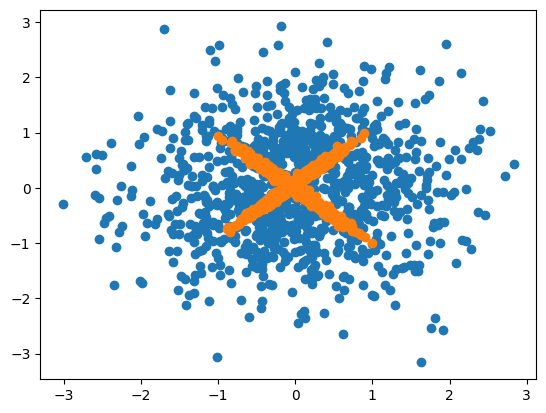

In [2]:
# example data

#x = np.random.normal(0, 1, 1000)
#y = np.random.normal(x**2, 0.1)

from lsbi.stats import mixture_normal

dist = mixture_normal([0,0], [[0,0],[0,0]], 
                      np.array([[[1, 0.99],[0.99, 1]],[[1, -0.99],[-0.99, 1]]]))
samples = dist.rvs(1000)
x = samples[:, 0]
y = samples[:, 1]

noise_distribution = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 1000)

plt.scatter(noise_distribution[:, 0], noise_distribution[:, 1])

normx = 2*(x - x.min()) / (x.max() - x.min()) - 1
normy = 2*(y - y.min()) / (y.max() - y.min()) - 1
plt.scatter(normx, normy)


Build the pytorch network.

In [3]:
class net(nn.Module):
    def __init__(self, input_dim, num_layers, hlsize):
        super(net, self).__init__()

        self.fc = [nn.Linear(input_dim+1, hlsize),
                     nn.ReLU()]
        for i in range(num_layers):
            self.fc.append(nn.Linear(hlsize, hlsize))
            self.fc.append(nn.ReLU())
        self.fc.append(nn.Linear(hlsize, input_dim))

        self.network = nn.Sequential(*self.fc)
        
    def forward(self, x):
        x = self.network(x)
        return x

lr = 0.001
batch_size=25 # need to implement batching
num_layers = 10
input_dim = 2
hlsize = 100

model = net(input_dim, num_layers, hlsize)
print(model)

net(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): Linear(in_features=100, out_features=100, bias=True)
    (15): ReLU()
    (16): Linear(in_features=100, out_features=100, bias=True)
    (17): ReLU()
    (18): Linear(in_features=100, out_features=100, bias=True)
    (19): ReLU()
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ReLU()
    (22): Linear(in_features=100, out_features=2, bias=True)
  )
)


Train the network

Epoch:  0 Loss:  0.9862134397029877  Best Loss:  inf  Count:  0


/var/folders/t3/5g06g87x3k32kcs57k9p9y1r0000gn/T/ipykernel_82389/3618872516.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0)
/var/folders/t3/5g06g87x3k32kcs57k9p9y1r0000gn/T/ipykernel_82389/3618872516.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1)


Epoch:  1 Loss:  0.8191357590258121  Best Loss:  0.9862134397029877  Count:  0
Epoch:  2 Loss:  0.8124751567840576  Best Loss:  0.8191357590258121  Count:  0
Epoch:  3 Loss:  0.790241663902998  Best Loss:  0.8124751567840576  Count:  0
Epoch:  4 Loss:  0.7864282205700874  Best Loss:  0.790241663902998  Count:  0
Epoch:  5 Loss:  0.7891359560191631  Best Loss:  0.7864282205700874  Count:  0
Epoch:  6 Loss:  0.77442442253232  Best Loss:  0.7864282205700874  Count:  1
Epoch:  7 Loss:  0.7647546000778676  Best Loss:  0.77442442253232  Count:  0
Epoch:  8 Loss:  0.7015428349375725  Best Loss:  0.7647546000778676  Count:  0
Epoch:  9 Loss:  0.6362879492342473  Best Loss:  0.7015428349375725  Count:  0
Epoch:  10 Loss:  0.6353009305894375  Best Loss:  0.6362879492342473  Count:  0
Epoch:  11 Loss:  0.5720055274665355  Best Loss:  0.6353009305894375  Count:  0
Epoch:  12 Loss:  0.5788853347301484  Best Loss:  0.5720055274665355  Count:  0
Epoch:  13 Loss:  0.5683882363140583  Best Loss:  0.572

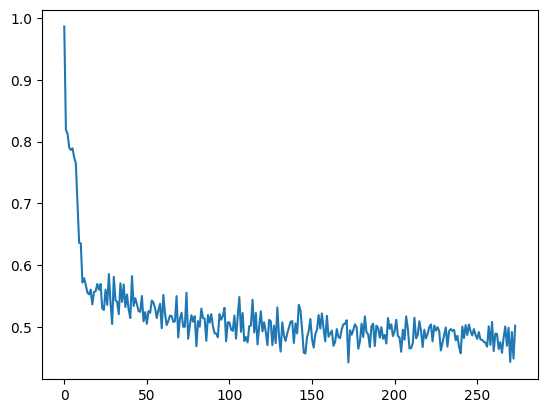

In [4]:
epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def loss(x0, x1, sigma0):

    # x0 is noise and x1 is the data distribution
    x0 = torch.tensor(x0)
    x1 = torch.tensor(x1)
    t = torch.rand((batch_size, 1))
    noise = torch.randn((batch_size, 2))
    psi0 = t * x1 + (1 - t) * x0 
    smoothing = sigma0 * noise
    """plt.scatter(psi0[:, 0], psi0[:, 1])
    plt.scatter(smoothing[:, 0], smoothing[:, 1])
    plt.scatter(t*x1[:, 0], t*x1[:, 1])
    plt.scatter((1-t)*x0[:, 0], (1-t)*x0[:, 1])
    plt.show()"""
    psi0 = psi0 + smoothing
    output = model(torch.tensor(np.column_stack((psi0, t)).astype(np.float32)))
    psi = x1 - x0
    return (output - psi).pow(2).mean()

"""for param in model.parameters():
    print(param)"""
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(np.column_stack((noise_distribution, normx, normy)).astype(np.float32)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

sigma0 = 0.1
patience = 100
c = np.inf
count = 0
loss_history = []
for i in range(epochs):
    loss_over_batch = []
    for batch_X in train_loader:
        optimizer.zero_grad()
        l = loss(batch_X[0][:, :2], batch_X[0][:, 2:], sigma0)
        l.backward()
        optimizer.step()
        loss_over_batch.append(l.item())
    print('Epoch: ', str(i) + ' Loss: ', np.mean(loss_over_batch), ' Best Loss: ', c, ' Count: ', count)
    loss_history.append(np.mean(loss_over_batch))
    if loss_history[-1] < c:
        c = loss_history[-1]
        best_model = model.state_dict()
        count = 0
    else:
        count += 1
    if count > patience:
        break

model.load_state_dict(best_model)

plt.plot(loss_history)


Make predictions for samples with the network. Using Euler method for solvign the ODE.

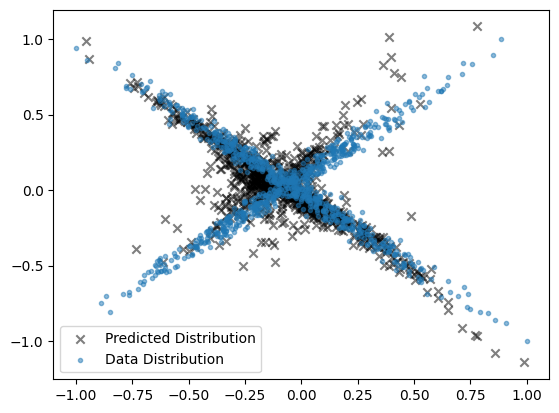

In [5]:
def predict(x0, x1, sigma0, t):
    x0 = torch.tensor(x0)
    x1 = torch.tensor(x1)
    t = torch.tensor(np.array([t]*len(x0)).reshape(-1, 1))
    noise = torch.randn((len(x0), 2))
    psi0 = t * x1 + (1 - t) * x0 + sigma0 * noise
    output = model(torch.tensor(np.column_stack((psi0, t)).astype(np.float32)))
    #print((output - (x1 - x0)).pow(2).mean())
    return output.detach().numpy()

#xtest = np.random.normal(0, 1, (1000, 2))
test_noise_distribution = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 1000)
xtest = test_noise_distribution.copy()
t = np.linspace(0, 1, 100)
deltat = np.diff(t)[0]

for i in range(len(t)):
    xprime = xtest + predict(
        test_noise_distribution, xtest, sigma0, t[i])*deltat
    xtest = xprime.copy()

    """if i%100 == 0:
        plt.scatter(xtest[:, 0], xtest[:, 1], c='r', alpha=0.1)"""
plt.scatter(xtest[:, 0], xtest[:, 1], c='k', alpha=0.5, marker='x', label='Predicted Distribution')
plt.scatter(normx, normy, alpha=0.5, marker='.', label='Data Distribution')
plt.legend()


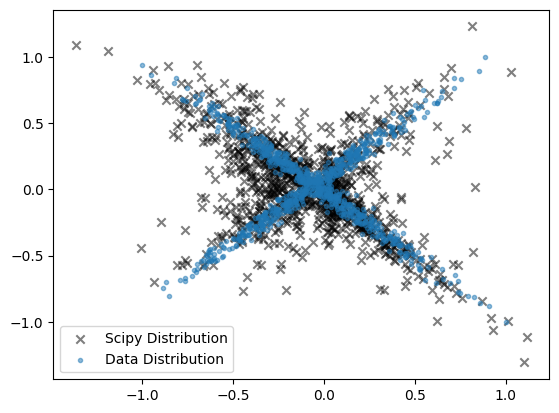

In [6]:
# seems super slow... might not have everything right here...
from scipy.integrate import odeint, solve_ivp

def func(x, t):
    # hmm not sure about this... might not need the psi0 bit...
    x = x.reshape(-1, 2)
    t = np.array([t]*len(x)).reshape(-1, 1)
    return model(torch.tensor(np.column_stack((x, t)).astype(np.float32))).detach().numpy().flatten()

t = np.linspace(0, 1, 10)
scipy_x = odeint(func, test_noise_distribution.flatten(), t)#.reshape(-1, 2)

solution = scipy_x[-1].reshape(-1, 2)

plt.scatter(solution[:, 0], solution[:, 1], c='k', alpha=0.5, marker='x', label='Scipy Distribution')
plt.scatter(normx, normy, alpha=0.5, marker='.', label='Data Distribution')
plt.legend()

Want to also be able to calculate log probabilities...